In [688]:
import time
from math import cos, pi, exp, e
import numpy
from numba import njit, jit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [689]:
y = 5
n_args_count = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 100  # максимальный вес рыбы

##Реализация алгоритма

In [690]:
# @njit()
# @jit(nopython=True)
def main_function():
    step_ind = list()
    step_vol = list()
    p_qbest_list = list()  # массив p_qbest в разные моменты поколений
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    step_ind.append(1)
    step_vol.append(1)
    w = list()
    w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    P = list()  # Начальная популяция
    P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list.append(p_qbest)

    f_t = list()
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t.append(f_I)

    # значение функции для каждого агента
    F = [numpy.array(f_t)]
    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        step_vol.append(step_vol[0] * exp(-y * t / iter_max))

        P.append(numpy.copy(P[t - 1]))
        w.append(numpy.copy(w[t - 1]))
        F.append(numpy.zeros(number_of_agents))
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]):
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list.append(p_qbest)

    return p_qbest_list

In [691]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [692]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - 2,
                     numpy.zeros(10) + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [693]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [694]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [695]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.10283035 0.04856253]
The function value of pqbest:		2.4904785569044208
Algorithm running time:			1.2726223468780518 s


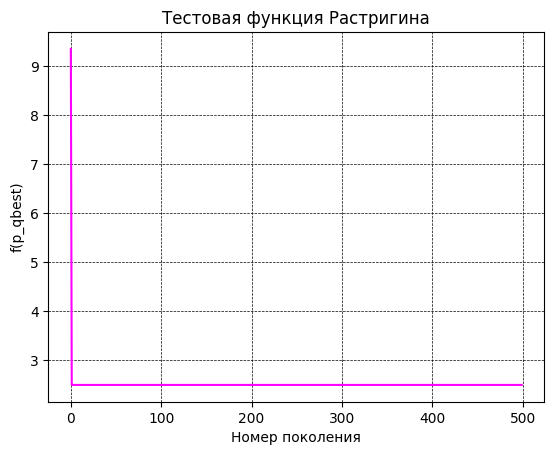

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.95533703  1.01462875]
The function value of pqbest:		2.3755292089251725
Algorithm running time:			1.2277061939239502 s


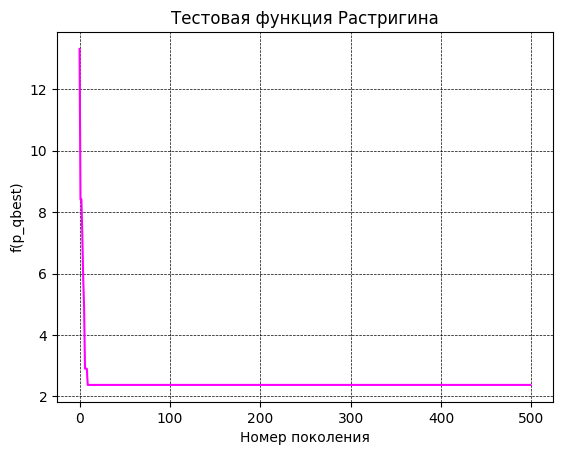

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[1.98330933 1.01603111]
The function value of pqbest:		5.0714601248229485
Algorithm running time:			1.1565179824829102 s


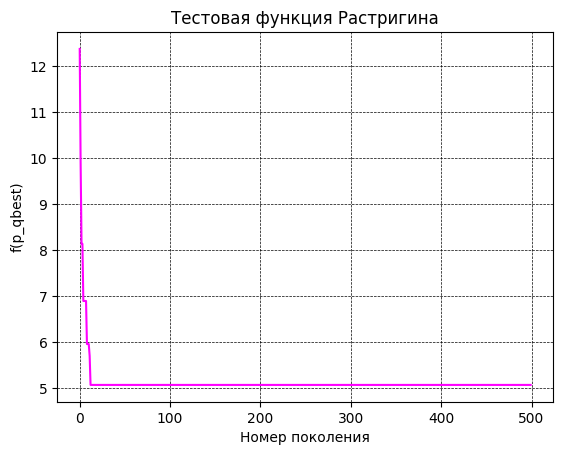

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.08338175 -0.05785419]
The function value of pqbest:		2.0050162953091544
Algorithm running time:			1.159986972808838 s


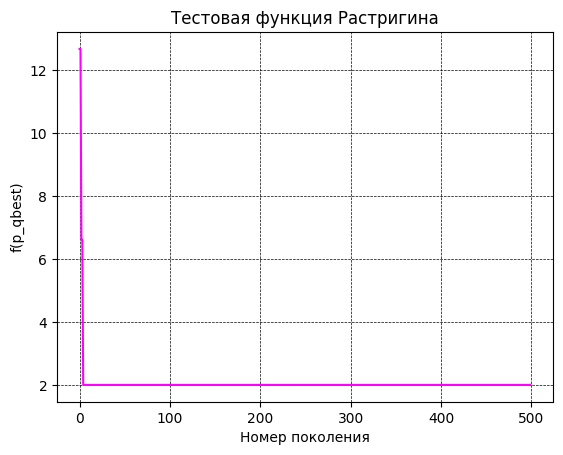

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.00865015 -1.03237867]
The function value of pqbest:		1.2868755737692332
Algorithm running time:			1.1807973384857178 s


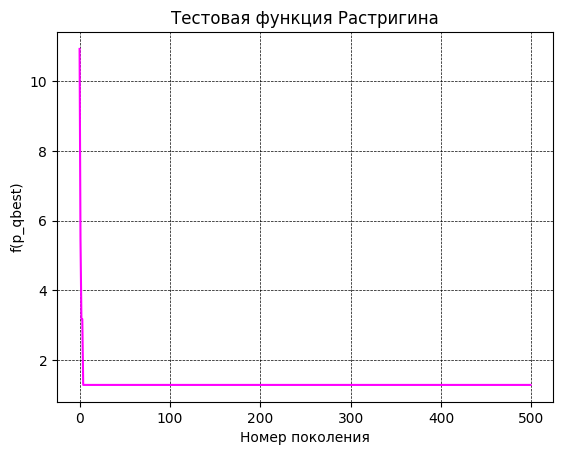

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 0.02743706 -0.85550903]
The function value of pqbest:		4.726565330502968
Algorithm running time:			1.1974899768829346 s


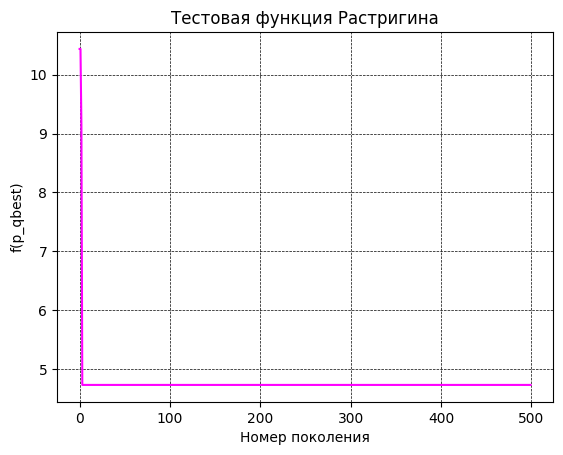

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.00216786  0.07267125]
The function value of pqbest:		1.0306765590715976
Algorithm running time:			1.2107150554656982 s


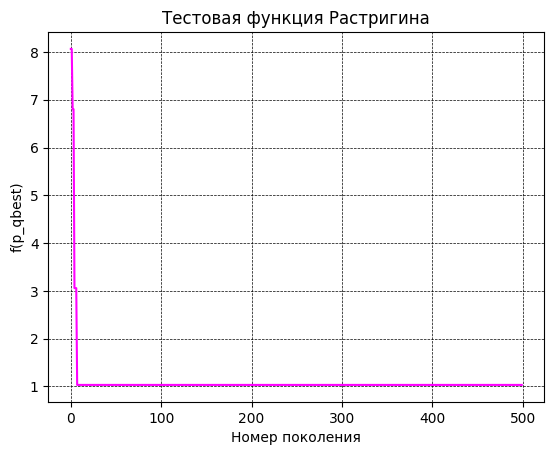

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.01875668 -1.09600177]
The function value of pqbest:		3.0356734208855016
Algorithm running time:			1.2087149620056152 s


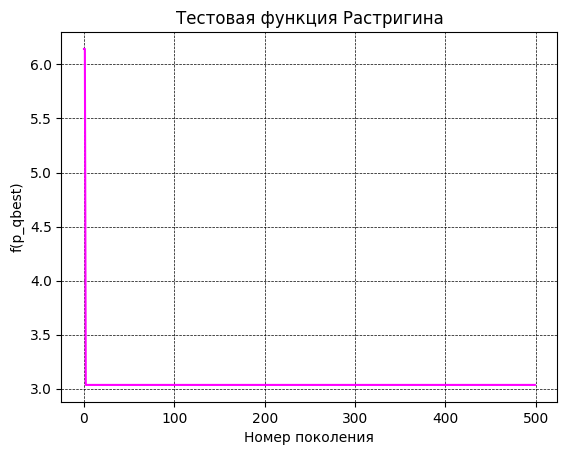

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.07468898  1.00478689]
The function value of pqbest:		2.100777865541964
Algorithm running time:			1.1930012702941895 s


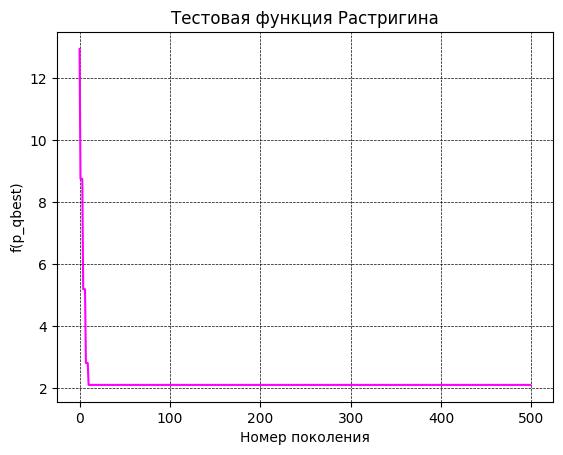

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[1.07352905 0.00382262]
The function value of pqbest:		2.203720394570567
Algorithm running time:			1.1502797603607178 s


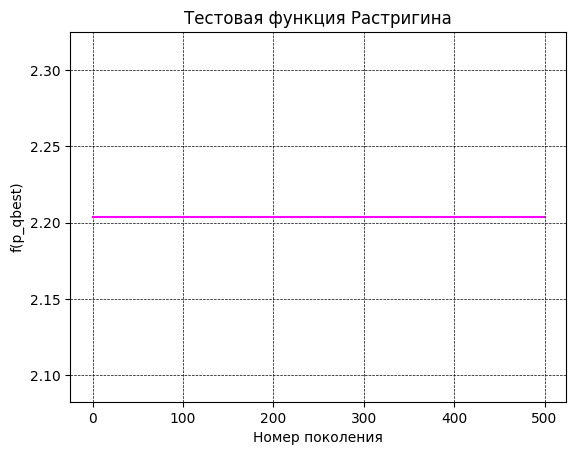

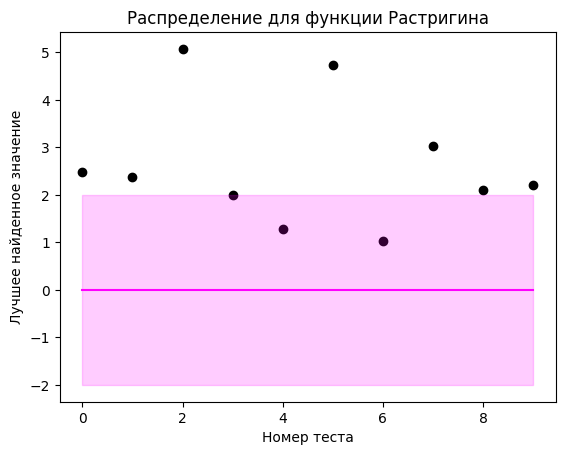

In [696]:
start_test("Растригина")

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [697]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * (0.5 * (x[0] ** 2 + x[1] ** 2)) ** 0.5) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [698]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5, 5, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.04048564 0.06480722]
The function value of pqbest:		0.3655056996054675
Algorithm running time:			1.107330560684204 s


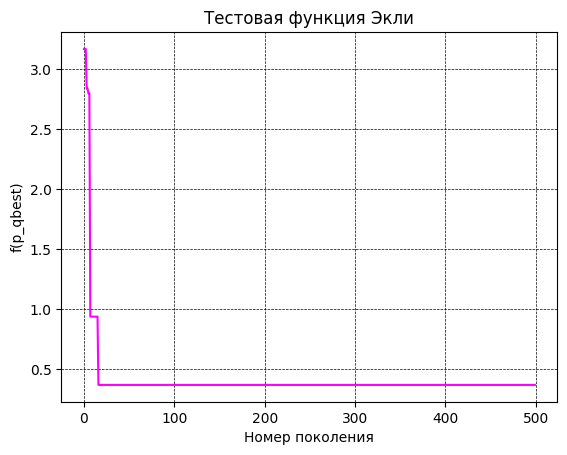

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.16486207 -0.02496554]
The function value of pqbest:		1.0700160087236341
Algorithm running time:			1.0947420597076416 s


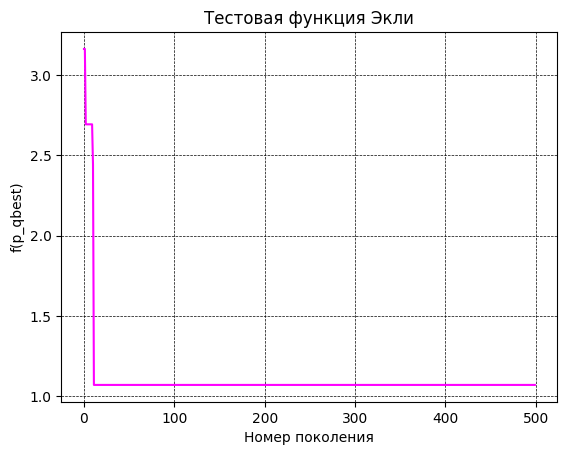

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.1109627 -0.0126973]
The function value of pqbest:		0.6166205237345075
Algorithm running time:			1.107865571975708 s


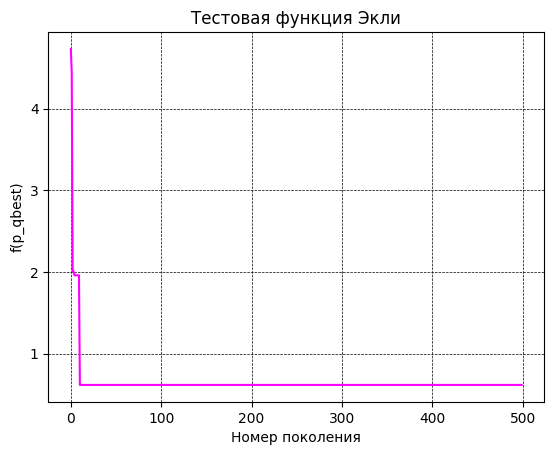

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.02050411 -0.00483453]
The function value of pqbest:		0.07136055074263226
Algorithm running time:			1.081526279449463 s


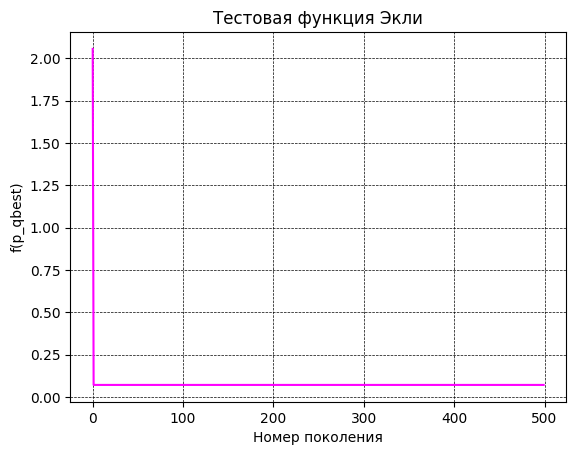

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.03027544 0.12147327]
The function value of pqbest:		0.7242645478031733
Algorithm running time:			1.0780065059661865 s


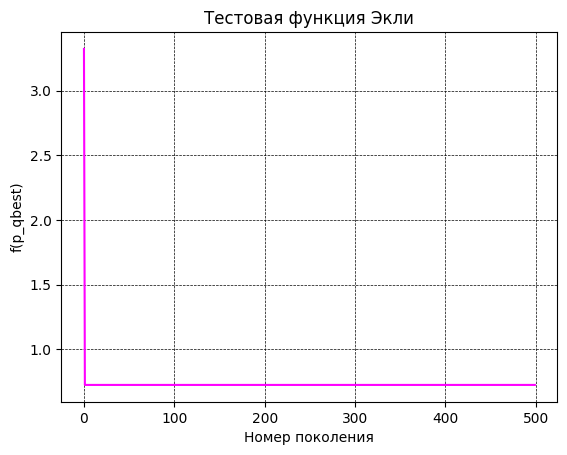

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 0.02491702 -0.02964337]
The function value of pqbest:		0.14906471232832175
Algorithm running time:			1.0787465572357178 s


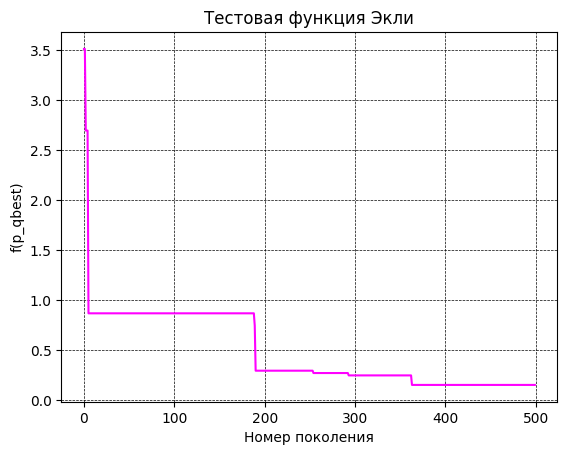

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.01273654  0.06635508]
The function value of pqbest:		0.3083265175070977
Algorithm running time:			1.078270435333252 s


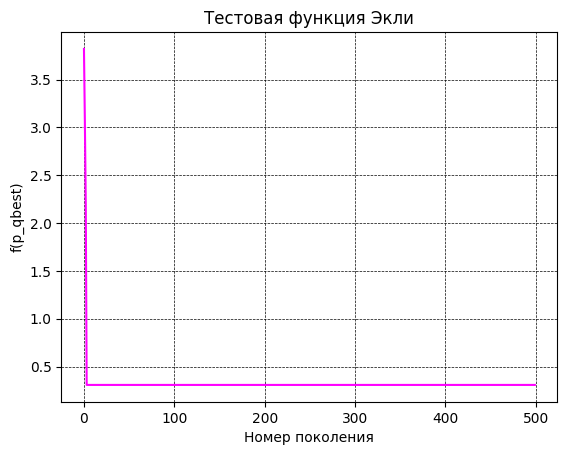

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.18024529 0.02905349]
The function value of pqbest:		1.2064735642002127
Algorithm running time:			1.0980923175811768 s


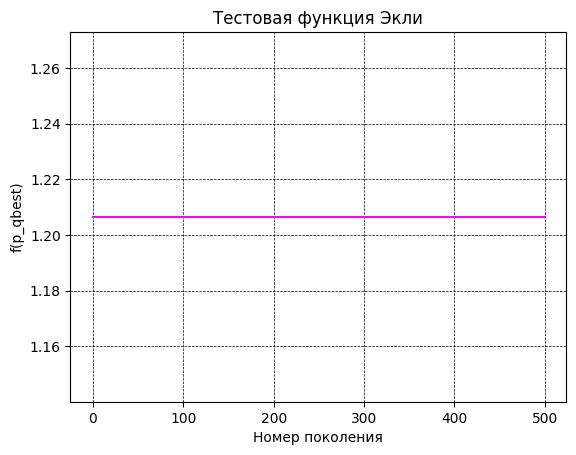

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.12580756 -0.25771497]
The function value of pqbest:		2.1256655274866247
Algorithm running time:			1.0863561630249023 s


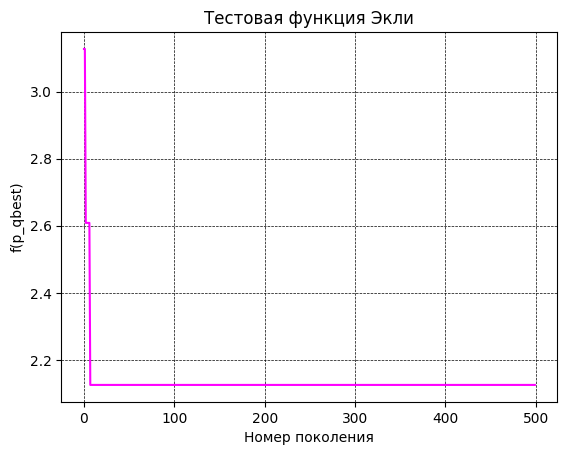

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.08633805 -0.06822257]
The function value of pqbest:		0.6090178607529708
Algorithm running time:			1.0889732837677002 s


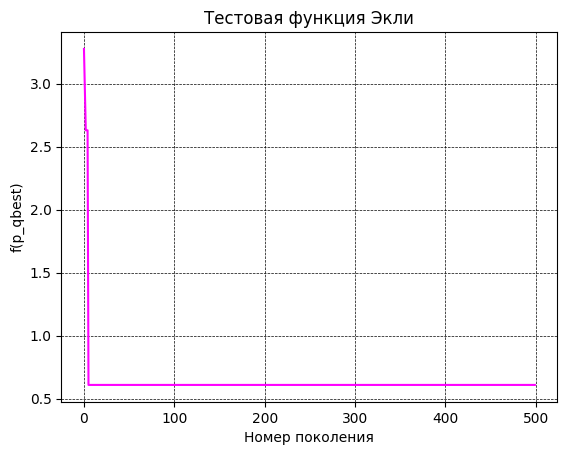

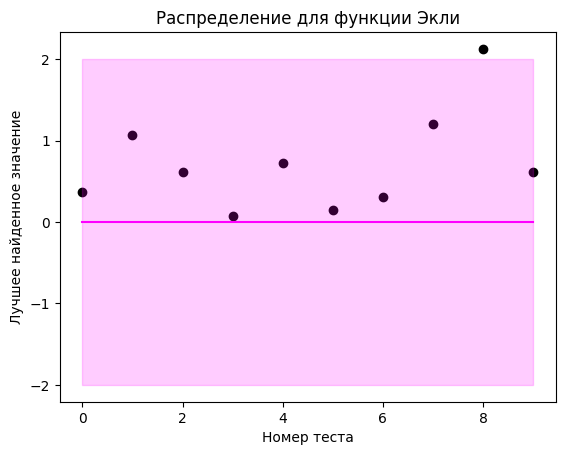

In [699]:
start_test("Экли")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [700]:
# @njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i ** 2
    return result

##Генерация начальных агентов

In [701]:
# @njit()
# @jit(nopython=True)
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-32767, 32767, n_args_count)
    return result

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-4743.91111066  1570.50379082]
The function value of pqbest:		24971174.782877933
Algorithm running time:			1.1585428714752197 s


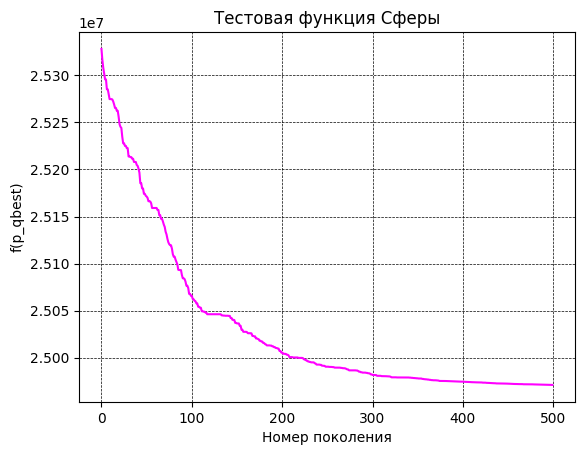

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[  894.12077679 -2752.13459581]
The function value of pqbest:		8373696.796947587
Algorithm running time:			1.057981014251709 s


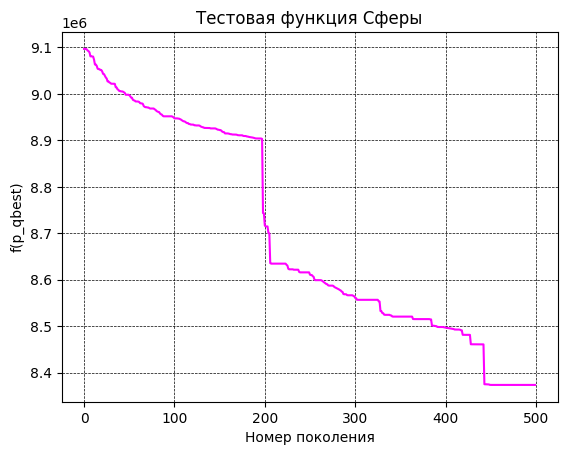

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[4852.40732327  546.84769181]
The function value of pqbest:		23844899.22895288
Algorithm running time:			1.0472803115844727 s


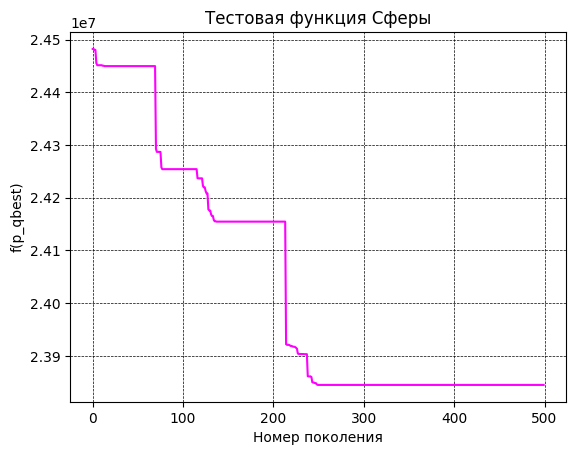

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-1417.92047442  6480.54065871]
The function value of pqbest:		44007905.70094796
Algorithm running time:			1.1003429889678955 s


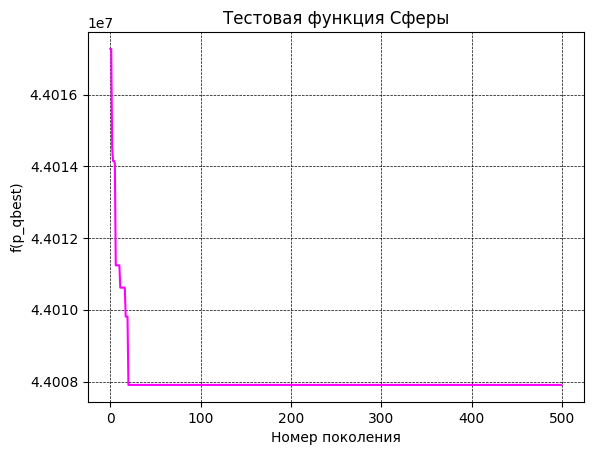

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 2001.7000852  -3140.52273919]
The function value of pqbest:		13869686.306469183
Algorithm running time:			1.0463883876800537 s


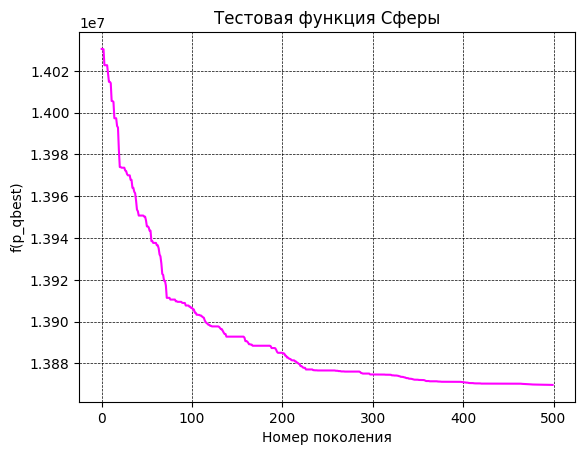

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-3579.23160573   132.90945841]
The function value of pqbest:		12828563.811605247
Algorithm running time:			1.047593116760254 s


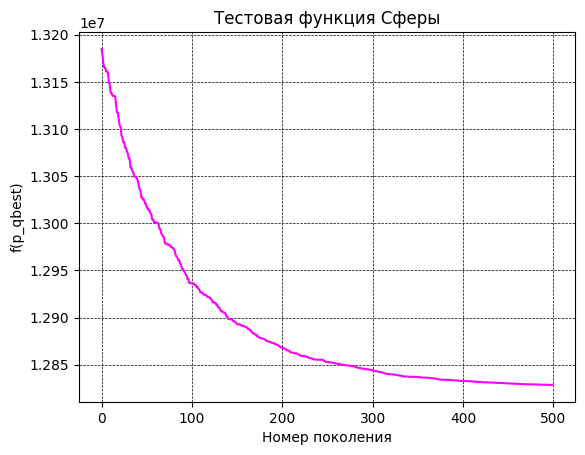

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[2402.11412889 4104.96224533]
The function value of pqbest:		22620867.32376205
Algorithm running time:			1.085420846939087 s


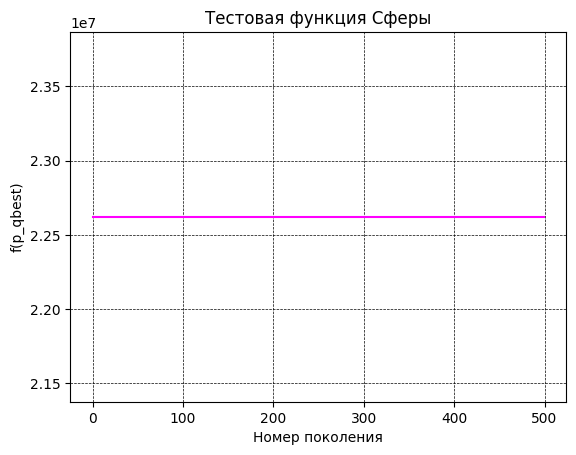

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[2060.82912628 -589.31336574]
The function value of pqbest:		4594306.930747954
Algorithm running time:			1.054081916809082 s


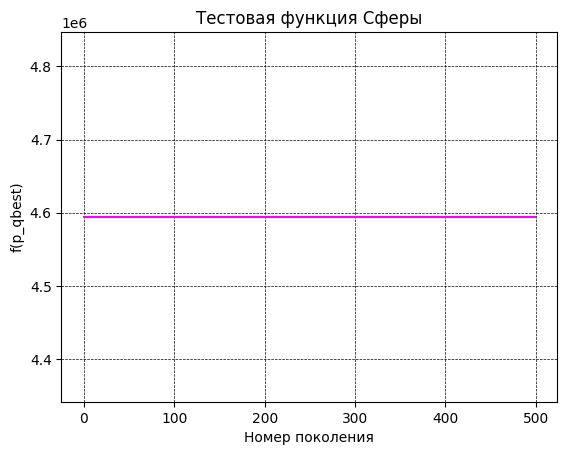

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-1454.45698841  4317.33599015]
The function value of pqbest:		20754835.182995312
Algorithm running time:			1.055426836013794 s


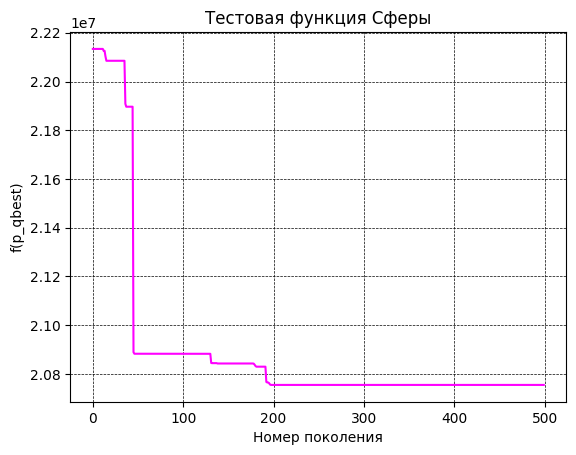

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[1087.84795144 1046.8117827 ]
The function value of pqbest:		2279228.0738433963
Algorithm running time:			1.0879402160644531 s


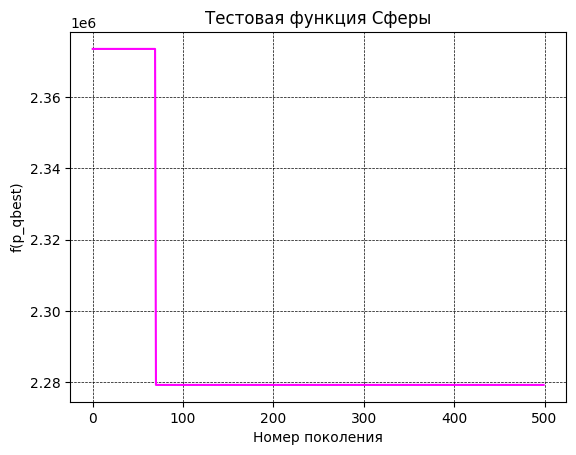

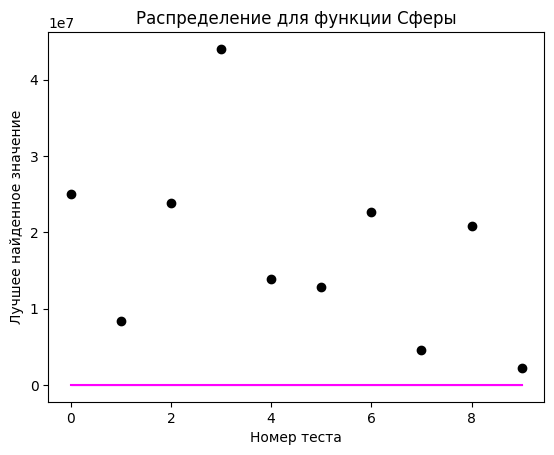

In [702]:
start_test("Сферы")
